# WE10 - RNN

Predicting stock price.

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Reading the Dataset

In [2]:
import pandas as pd

import yfinance as yf

# Define the ticker symbol for Berkshire Hathaway
ticker = "TSLA"

# Get the stock data from Yahoo Finance for the past 10 days
data = yf.download(ticker, period="100d", interval="1d")

# Extract the closing prices for the past 9 days
stock_price = data["Close"][-100:]

[*********************100%***********************]  1 of 1 completed


In [3]:
# Convert the Series to a DataFrame with headers
df = pd.DataFrame({'Date': stock_price.index, 'ClosePrice': stock_price.values})

df.head()

,Date,ClosePrice
0,2022-11-28,182.919998
1,2022-11-29,180.830002
2,2022-11-30,194.699997
3,2022-12-01,194.699997
4,2022-12-02,194.860001


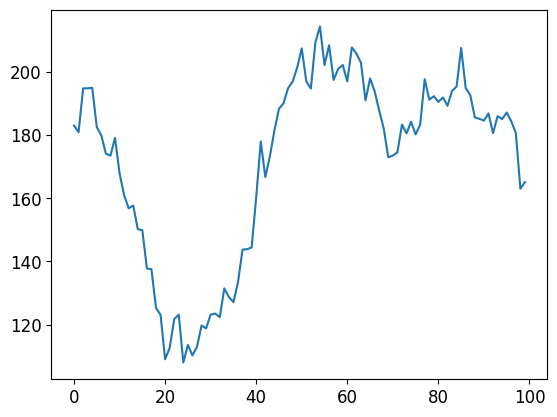

In [4]:
#Plot Stock Closing Price

plt.plot(df['ClosePrice'])
plt.show()

# Data Cleanup

## RESHAPE the data set!

In [5]:
df.shape

(100, 2)

In [6]:
# we will reshape by 10

df.shape[0]/10

10.0

In [7]:
df.groupby(['Date']).count()

,ClosePrice
Date,
2022-11-28,1
2022-11-29,1
2022-11-30,1
2022-12-01,1
2022-12-02,1
...,...
2023-04-17,1
2023-04-18,1
2023-04-19,1


In [8]:
# Find the reading count for each day

df_count = pd.DataFrame(df.groupby(['Date']).count()['ClosePrice'])

df_count

,ClosePrice
Date,
2022-11-28,1
2022-11-29,1
2022-11-30,1
2022-12-01,1
2022-12-02,1
...,...
2023-04-17,1
2023-04-18,1
2023-04-19,1


In [9]:
# Re-organize the data set by day 
temp = np.array(df['ClosePrice']).reshape(10,10)

temp

array([[182.91999817, 180.83000183, 194.69999695, 194.69999695,
        194.86000061, 182.44999695, 179.82000732, 174.03999329,
        173.44000244, 179.05000305],
       [167.82000732, 160.94999695, 156.80000305, 157.66999817,
        150.22999573, 149.86999512, 137.80000305, 137.57000732,
        125.34999847, 123.15000153],
       [109.09999847, 112.70999908, 121.81999969, 123.18000031,
        108.09999847, 113.63999939, 110.33999634, 113.05999756,
        119.76999664, 118.84999847],
       [123.22000122, 123.55999756, 122.40000153, 131.49000549,
        128.77999878, 127.16999817, 133.41999817, 143.75      ,
        143.88999939, 144.42999268],
       [160.27000427, 177.8999939 , 166.66000366, 173.22000122,
        181.41000366, 188.27000427, 189.97999573, 194.75999451,
        196.80999756, 201.28999329],
       [207.32000732, 196.88999939, 194.63999939, 209.25      ,
        214.24000549, 202.03999329, 208.30999756, 197.36999512,
        200.86000061, 202.07000732],
       [19

In [10]:
# Convert to dataframe

conv_df = pd.DataFrame(temp, columns=np.arange(0,10,1))

conv_df

,0,1,2,3,4,5,6,7,8,9
0,182.919998,180.830002,194.699997,194.699997,194.860001,182.449997,179.820007,174.039993,173.440002,179.050003
1,167.820007,160.949997,156.800003,157.669998,150.229996,149.869995,137.800003,137.570007,125.349998,123.150002
2,109.099998,112.709999,121.820000,123.180000,108.099998,113.639999,110.339996,113.059998,119.769997,118.849998
3,123.220001,123.559998,122.400002,131.490005,128.779999,127.169998,133.419998,143.750000,143.889999,144.429993
4,160.270004,177.899994,166.660004,173.220001,181.410004,188.270004,189.979996,194.759995,196.809998,201.289993
5,207.320007,196.889999,194.639999,209.250000,214.240005,202.039993,208.309998,197.369995,200.860001,202.070007
6,196.880005,207.630005,205.710007,202.770004,190.899994,197.789993,193.809998,187.710007,182.000000,172.919998
7,173.440002,174.479996,183.259995,180.449997,184.130005,180.130005,183.250000,197.580002,191.149994,192.220001
8,190.410004,191.809998,189.190002,193.880005,195.279999,207.460007,194.770004,192.580002,185.520004,185.059998
9,184.509995,186.789993,180.539993,185.899994,185.000000,187.039993,184.309998,180.589996,162.990005,165.080002


# Reshape for Standardizing Data

In [11]:
# Let's create a single sequence (i.e., feature) for standardization

std_df = np.array(conv_df).ravel().reshape(-1,1)

std_df.shape

(100, 1)

In [12]:
std_df

array([[182.91999817],
       [180.83000183],
       [194.69999695],
       [194.69999695],
       [194.86000061],
       [182.44999695],
       [179.82000732],
       [174.03999329],
       [173.44000244],
       [179.05000305],
       [167.82000732],
       [160.94999695],
       [156.80000305],
       [157.66999817],
       [150.22999573],
       [149.86999512],
       [137.80000305],
       [137.57000732],
       [125.34999847],
       [123.15000153],
       [109.09999847],
       [112.70999908],
       [121.81999969],
       [123.18000031],
       [108.09999847],
       [113.63999939],
       [110.33999634],
       [113.05999756],
       [119.76999664],
       [118.84999847],
       [123.22000122],
       [123.55999756],
       [122.40000153],
       [131.49000549],
       [128.77999878],
       [127.16999817],
       [133.41999817],
       [143.75      ],
       [143.88999939],
       [144.42999268],
       [160.27000427],
       [177.8999939 ],
       [166.66000366],
       [173

## Standardize the values

In [13]:
# Next, standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

std_stock = scaler.fit_transform(std_df)

## Reshape the data back 

In [14]:
stock_reshaped = std_stock.reshape(10,10)

stock_reshaped.shape

(10, 10)

In [15]:
#Pandas version of the reshaped data

pd.DataFrame(stock_reshaped, columns=np.arange(0,10,1))

,0,1,2,3,4,5,6,7,8,9
0,0.389370,0.318286,0.790026,0.790026,0.795468,0.373385,0.283935,0.087348,0.066942,0.257746
1,-0.124203,-0.357862,-0.499010,-0.469420,-0.722466,-0.734710,-1.145228,-1.153051,-1.568672,-1.643497
2,-2.121358,-1.998577,-1.688732,-1.642477,-2.155370,-1.966946,-2.079184,-1.986673,-1.758456,-1.789746
3,-1.641116,-1.629552,-1.669005,-1.359841,-1.452012,-1.506771,-1.294199,-0.942860,-0.938098,-0.919732
4,-0.380990,0.218633,-0.163656,0.059459,0.338013,0.571332,0.629491,0.792066,0.861790,1.014161
5,1.219251,0.864511,0.787985,1.284893,1.454611,1.039670,1.252922,0.880836,0.999537,1.040691
6,0.864171,1.229795,1.164493,1.064499,0.660782,0.895121,0.759756,0.552286,0.358080,0.049255
7,0.066942,0.102313,0.400934,0.305362,0.430525,0.294479,0.400594,0.887979,0.669285,0.705677
8,0.644117,0.691733,0.602623,0.762137,0.809753,1.224013,0.792407,0.717922,0.477801,0.462155
9,0.443449,0.520995,0.308423,0.490725,0.460114,0.529498,0.436646,0.310124,-0.288479,-0.217395


# Split the Data

**In certain cases, we cannot use a random split. For example, if we are trying to predict the stock market, we cannot use a random split. We need to use a chronological split.**

BUT, keep in mind if we have something like hourly readings of dayly temperature, we can use a random split on days, but the sequence of the temperature within the day is important to remain sequential.

In this case, we are not using random split because we are using stock market data.

In [16]:
from sklearn.model_selection import train_test_split


# if we neede to maintain the ordering of the data, we can use the following code to split the data
split_point = int(len(stock_reshaped)*0.7)
train, test = stock_reshaped[:split_point], stock_reshaped[split_point:]

In [17]:
train.shape

(7, 10)

In [18]:
train[:2]

array([[ 0.38937039,  0.31828648,  0.79002582,  0.79002582,  0.79546778,
         0.37338495,  0.28393506,  0.08734811,  0.06694152,  0.25774606],
       [-0.12420294, -0.35786229, -0.49900981, -0.46941997, -0.72246561,
        -0.73470977, -1.1452283 , -1.1530508 , -1.56867162, -1.64349682]])

In [19]:
test.shape

(3, 10)

In [20]:
test[:2]

array([[0.06694152, 0.10231326, 0.40093418, 0.30536195, 0.43052454,
        0.29447854, 0.40059425, 0.8879791 , 0.66928489, 0.70567744],
       [0.64411671, 0.6917326 , 0.60262264, 0.76213666, 0.80975255,
        1.22401288, 0.79240687, 0.7179216 , 0.4778005 , 0.46215498]])

# Create Input and Target values

The first 9 days will be input to predict the 10th reading (i.e., target)

In [21]:
# The first 9 columns are inputs

train_inputs = train[:,:9]


pd.DataFrame(train_inputs, columns=np.arange(0,9,1))

,0,1,2,3,4,5,6,7,8
0,0.389370,0.318286,0.790026,0.790026,0.795468,0.373385,0.283935,0.087348,0.066942
1,-0.124203,-0.357862,-0.499010,-0.469420,-0.722466,-0.734710,-1.145228,-1.153051,-1.568672
2,-2.121358,-1.998577,-1.688732,-1.642477,-2.155370,-1.966946,-2.079184,-1.986673,-1.758456
3,-1.641116,-1.629552,-1.669005,-1.359841,-1.452012,-1.506771,-1.294199,-0.942860,-0.938098
4,-0.380990,0.218633,-0.163656,0.059459,0.338013,0.571332,0.629491,0.792066,0.861790
5,1.219251,0.864511,0.787985,1.284893,1.454611,1.039670,1.252922,0.880836,0.999537
6,0.864171,1.229795,1.164493,1.064499,0.660782,0.895121,0.759756,0.552286,0.358080


## Add one more dimension to make it ready for RNNs

See here for more details: https://keras.io/layers/recurrent/, and https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e


In [22]:
train_inputs

array([[ 0.38937039,  0.31828648,  0.79002582,  0.79002582,  0.79546778,
         0.37338495,  0.28393506,  0.08734811,  0.06694152],
       [-0.12420294, -0.35786229, -0.49900981, -0.46941997, -0.72246561,
        -0.73470977, -1.1452283 , -1.1530508 , -1.56867162],
       [-2.12135849, -1.99857696, -1.68873218, -1.64247652, -2.15536999,
        -1.96694625, -2.0791843 , -1.98667298, -1.75845585],
       [-1.64111602, -1.62955224, -1.66900544, -1.35984078, -1.45201217,
        -1.5067707 , -1.29419883, -0.94285998, -0.93809839],
       [-0.38098986,  0.21863252, -0.1636564 ,  0.05945895,  0.33801322,
         0.57133212,  0.6294915 ,  0.79206642,  0.8617901 ],
       [ 1.21925129,  0.86451108,  0.78798521,  1.28489324,  1.45461081,
         1.0396701 ,  1.25292235,  0.88083646,  0.99953678],
       [ 0.86417116,  1.22979478,  1.16449276,  1.06449887,  0.66078202,
         0.89512123,  0.7597556 ,  0.55228577,  0.35807988]])

In [23]:
train_inputs.shape 

(7, 9)

In [24]:
#Create an additional dimension for train

train_x = train_inputs[:,:,np.newaxis]

train_x.shape 

(7, 9, 1)

In [25]:
train_x

array([[[ 0.38937039],
        [ 0.31828648],
        [ 0.79002582],
        [ 0.79002582],
        [ 0.79546778],
        [ 0.37338495],
        [ 0.28393506],
        [ 0.08734811],
        [ 0.06694152]],

       [[-0.12420294],
        [-0.35786229],
        [-0.49900981],
        [-0.46941997],
        [-0.72246561],
        [-0.73470977],
        [-1.1452283 ],
        [-1.1530508 ],
        [-1.56867162]],

       [[-2.12135849],
        [-1.99857696],
        [-1.68873218],
        [-1.64247652],
        [-2.15536999],
        [-1.96694625],
        [-2.0791843 ],
        [-1.98667298],
        [-1.75845585]],

       [[-1.64111602],
        [-1.62955224],
        [-1.66900544],
        [-1.35984078],
        [-1.45201217],
        [-1.5067707 ],
        [-1.29419883],
        [-0.94285998],
        [-0.93809839]],

       [[-0.38098986],
        [ 0.21863252],
        [-0.1636564 ],
        [ 0.05945895],
        [ 0.33801322],
        [ 0.57133212],
        [ 0.6294915 ],
   

## Set the target

In [26]:
# The last column (9) is TARGET

train_target = train[:,-1]


pd.DataFrame(train_target, columns=['9'])

,9
0,0.257746
1,-1.643497
2,-1.789746
3,-0.919732
4,1.014161
5,1.040691
6,0.049255


## Repeat for TEST

In [27]:
test.shape

(3, 10)

In [28]:
# The first 9 columns (from 0 to 9) are inputs

test_inputs = test[:,:9]

In [29]:
#Create an additional dimension for test

test_x = test_inputs[:,:,np.newaxis]

test_x.shape 

(3, 9, 1)

In [30]:
# The last column (9) is TARGET

test_target = test[:,-1]


pd.DataFrame(test_target, columns=['9'])

,9
0,0.705677
1,0.462155
2,-0.217395


In [31]:
performance = pd.DataFrame({"model": [], "RMSE": []})

## Simple RNN with more layers

In [32]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.3850
Epoch 2/30
1/1 [==============================] - 0s 10ms/step - loss: 0.2742
Epoch 3/30
1/1 [==============================] - 0s 16ms/step - loss: 0.2139
Epoch 4/30
1/1 [==============================] - 0s 11ms/step - loss: 0.1882
Epoch 5/30
1/1 [==============================] - 0s 9ms/step - loss: 0.1824
Epoch 6/30
1/1 [==============================] - 0s 10ms/step - loss: 0.1836
Epoch 7/30
1/1 [==============================] - 0s 10ms/step - loss: 0.1838
Epoch 8/30
1/1 [==============================] - 0s 14ms/step - loss: 0.1788
Epoch 9/30
1/1 [==============================] - 0s 10ms/step - loss: 0.1671
Epoch 10/30
1/1 [==============================] - 0s 10ms/step - loss: 0.1520
Epoch 11/30
1/1 [==============================] - 0s 13ms/step - loss: 0.1354
Epoch 12/30
1/1 [==============================] - 0s 9ms/step - loss: 0.1198
Epoch 13/30
1/1 [==============================] - 0s 10ms/step -

### Predictions

In [34]:
#Predict:
y_pred = model.predict(test_x)


1/1 [==============================] - 0s 399ms/step


In [35]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [36]:
comparison

,actual,predicted
0,192.220001,191.061630
1,185.059998,188.060272
2,165.080002,172.414001


In [37]:
rmse = mean_squared_error(comparison['actual'], comparison['predicted'])

In [38]:
performance = pd.concat([performance, pd.DataFrame({'model':"Simple RNN", 
                                                    'RMSE': [rmse]}, index=[0])])

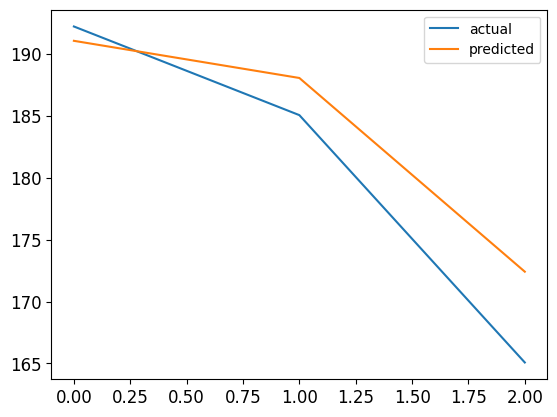

In [39]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [40]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 1.3944
Epoch 2/30
1/1 [==============================] - 0s 10ms/step - loss: 1.3112
Epoch 3/30
1/1 [==============================] - 0s 12ms/step - loss: 1.2326
Epoch 4/30
1/1 [==============================] - 0s 11ms/step - loss: 1.1576
Epoch 5/30
1/1 [==============================] - 0s 12ms/step - loss: 1.0858
Epoch 6/30
1/1 [==============================] - 0s 11ms/step - loss: 1.0167
Epoch 7/30
1/1 [==============================] - 0s 12ms/step - loss: 0.9500
Epoch 8/30
1/1 [==============================] - 0s 11ms/step - loss: 0.8855
Epoch 9/30
1/1 [==============================] - 0s 13ms/step - loss: 0.8231
Epoch 10/30
1/1 [==============================] - 0s 12ms/step - loss: 0.7629
Epoch 11/30
1/1 [==============================] - 0s 11ms/step - loss: 0.7051
Epoch 12/30
1/1 [==============================] - 0s 11ms/step - loss: 0.6500
Epoch 13/30
1/1 [==============================] - 0s 11ms/step

### Predictions

In [42]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 1s 922ms/step


In [43]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [44]:
rmse = mean_squared_error(comparison['actual'], comparison['predicted'])

In [45]:
performance = pd.concat([performance, pd.DataFrame({'model':"LSTM", 
                                                    'RMSE': [rmse]}, index=[0])])

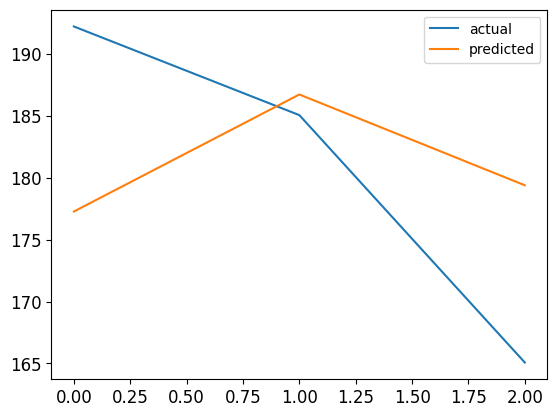

In [46]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [47]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 1.3223
Epoch 2/30
1/1 [==============================] - 0s 14ms/step - loss: 1.2010
Epoch 3/30
1/1 [==============================] - 0s 14ms/step - loss: 1.1139
Epoch 4/30
1/1 [==============================] - 0s 13ms/step - loss: 1.0415
Epoch 5/30
1/1 [==============================] - 0s 16ms/step - loss: 0.9773
Epoch 6/30
1/1 [==============================] - 0s 13ms/step - loss: 0.9166
Epoch 7/30
1/1 [==============================] - 0s 15ms/step - loss: 0.8582
Epoch 8/30
1/1 [==============================] - 0s 12ms/step - loss: 0.8019
Epoch 9/30
1/1 [==============================] - 0s 15ms/step - loss: 0.7478
Epoch 10/30
1/1 [==============================] - 0s 13ms/step - loss: 0.6956
Epoch 11/30
1/1 [==============================] - 0s 13ms/step - loss: 0.6448
Epoch 12/30
1/1 [==============================] - 0s 13ms/step - loss: 0.5955
Epoch 13/30
1/1 [==============================] - 0s 15ms/step

### Predictions

In [49]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 331ms/step


In [50]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [51]:
rmse = mean_squared_error(comparison['actual'], comparison['predicted'])

In [52]:
performance = pd.concat([performance, pd.DataFrame({'model':"GRU", 
                                                    'RMSE': [rmse]}, index=[0])])

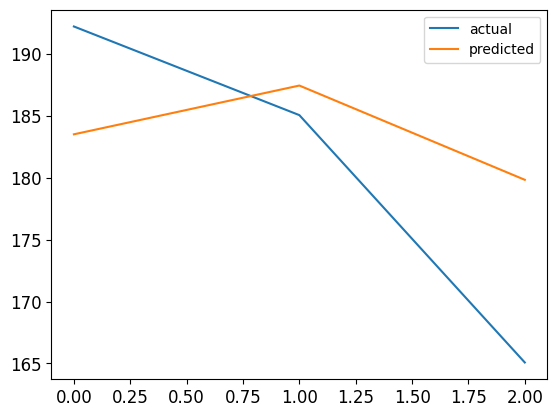

In [53]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [54]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [55]:
np.random.seed(142)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 1.3678
Epoch 2/30
1/1 [==============================] - 0s 65ms/step - loss: 1.2678
Epoch 3/30
1/1 [==============================] - 0s 44ms/step - loss: 1.1719
Epoch 4/30
1/1 [==============================] - 0s 53ms/step - loss: 1.0795
Epoch 5/30
1/1 [==============================] - 0s 48ms/step - loss: 0.9920
Epoch 6/30
1/1 [==============================] - 0s 49ms/step - loss: 0.9159
Epoch 7/30
1/1 [==============================] - 0s 44ms/step - loss: 0.8434
Epoch 8/30
1/1 [==============================] - 0s 41ms/step - loss: 0.7752
Epoch 9/30
1/1 [==============================] - 0s 11ms/step - loss: 0.7118
Epoch 10/30
1/1 [==============================] - 0s 12ms/step - loss: 0.6536
Epoch 11/30
1/1 [==============================] - 0s 42ms/step - loss: 0.5970
Epoch 12/30
1/1 [==============================] - 0s 11ms/step - loss: 0.5424
Epoch 13/30
1/1 [==============================] - 0s 12ms/step

### Predictions

In [56]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 349ms/step


In [57]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [58]:
rmse = mean_squared_error(comparison['actual'], comparison['predicted'])

In [59]:
performance = pd.concat([performance, pd.DataFrame({'model':"Conv 1D", 
                                                    'RMSE': [rmse]}, index=[0])])

In [60]:
performance

,model,RMSE
0,Simple RNN,21.377007
0,LSTM,143.699190
0,GRU,99.758078
0,Conv 1D,142.373542


###  We can see that the Simple RNN model achieved the lowest RMSE of 21.37, which suggests that it may be the best-performing model for predicting stock prices among the four models compared. On the other hand, the Conv 1D and GRU models achieved higher RMSE values, indicating that they may not perform as well as the Simple RNN model for this particular task. The LSTM model also achieved 143.69 a high RMSE value , suggesting that it may not be the best choice for predicting stock prices.